In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statistics

In [95]:
df = pd.read_excel('./data/gameScores_2015-2024.xlsx')
df

,date,visitor,home,visitor_points,home_points
0,2015-10-02,Denver Nuggets,Los Angeles Clippers,96,103
1,2015-10-03,Charlotte Hornets,Orlando Magic,106,100
2,2015-10-03,New Orleans Pelicans,Indiana Pacers,110,105
3,2015-10-04,Utah Jazz,Los Angeles Lakers,90,71
4,2015-10-04,Charlotte Hornets,Miami Heat,90,77
...,...,...,...,...,...
12792,2024-11-04,Portland Trail Blazers,New Orleans Pelicans,118,100
12793,2024-11-04,New York Knicks,Houston Rockets,97,109
12794,2024-11-04,Memphis Grizzlies,Brooklyn Nets,104,106
12795,2024-11-04,Utah Jazz,Chicago Bulls,135,126


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12797 entries, 0 to 12796
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            12797 non-null  object
 1   visitor         12797 non-null  object
 2   home            12797 non-null  object
 3   visitor_points  12797 non-null  int64 
 4   home_points     12797 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 500.0+ KB


In [97]:
# Take games between 2019 and current year
start_year = 2019
current_year = dt.datetime.now().year

# Convert to datetime data type
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtered the dataframe for games between start year and current year
filtered_df = df[(df['date'].dt.year >= start_year) & (df['date'].dt.year <= current_year)]

filtered_df.reset_index(drop=True)

,date,visitor,home,visitor_points,home_points
0,2019-01-01,Philadelphia 76ers,Los Angeles Clippers,119,113
1,2019-01-01,New York Knicks,Denver Nuggets,108,115
2,2019-01-01,Portland Trail Blazers,Sacramento Kings,113,108
3,2019-01-01,Utah Jazz,Toronto Raptors,116,122
4,2019-01-01,Detroit Pistons,Milwaukee Bucks,98,121
...,...,...,...,...,...
7807,2024-11-04,Portland Trail Blazers,New Orleans Pelicans,118,100
7808,2024-11-04,New York Knicks,Houston Rockets,97,109
7809,2024-11-04,Memphis Grizzlies,Brooklyn Nets,104,106
7810,2024-11-04,Utah Jazz,Chicago Bulls,135,126


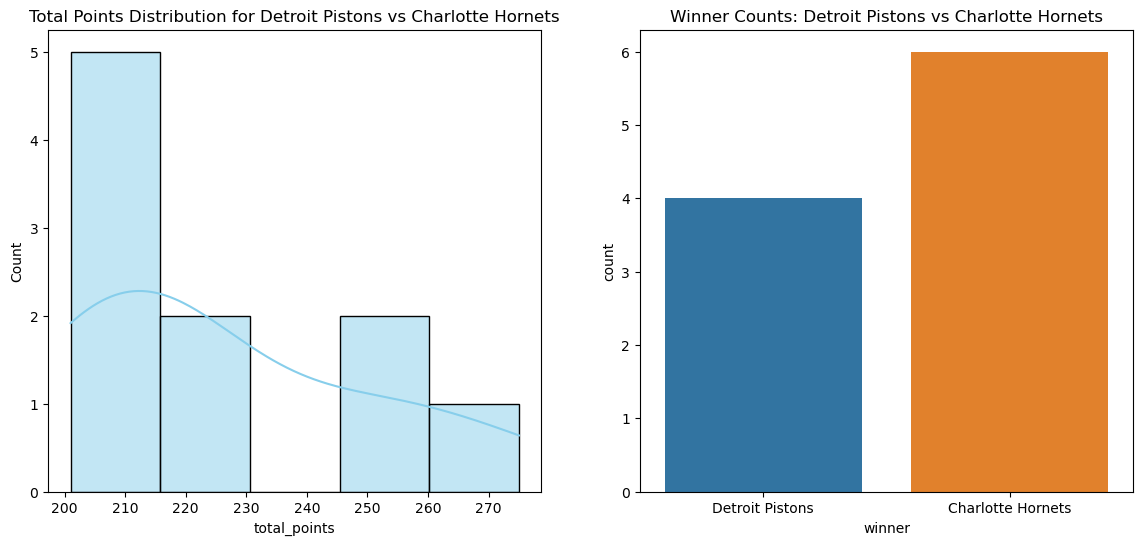

Statistics of Detroit Pistons vs Charlotte Hornets


Mean: 226.4
Standard Deviation: 25.06524818681568
------------------------------------
z-score for 221.5: -0.20
z-score for 222.5: -0.16
z-score for 223.5: -0.12
z-score for 224.5: -0.08
z-score for 225.5: -0.04
z-score for 226.5: 0.00
z-score for 227.5: 0.04
z-score for 228.5: 0.08
z-score for 229.5: 0.12
z-score for 230.5: 0.16
z-score for 231.5: 0.20
z-score for 232.5: 0.24
z-score for 233.5: 0.28
z-score for 234.5: 0.32
z-score for 235.5: 0.36


,date,visitor,home,visitor_points,home_points,total_points,winner
5881,2019-10-16,Detroit Pistons,Charlotte Hornets,116,110,226,Detroit Pistons
6070,2019-11-15,Detroit Pistons,Charlotte Hornets,106,109,215,Charlotte Hornets
6156,2019-11-27,Detroit Pistons,Charlotte Hornets,101,102,203,Charlotte Hornets
7661,2021-03-11,Detroit Pistons,Charlotte Hornets,102,105,207,Charlotte Hornets
8078,2021-05-01,Detroit Pistons,Charlotte Hornets,94,107,201,Charlotte Hornets
9001,2022-01-05,Detroit Pistons,Charlotte Hornets,111,140,251,Charlotte Hornets
9354,2022-02-27,Detroit Pistons,Charlotte Hornets,127,126,253,Detroit Pistons
10334,2022-12-14,Detroit Pistons,Charlotte Hornets,141,134,275,Detroit Pistons
10834,2023-02-27,Detroit Pistons,Charlotte Hornets,106,117,223,Charlotte Hornets
11326,2023-10-27,Detroit Pistons,Charlotte Hornets,111,99,210,Detroit Pistons


In [98]:
def possible_outcome(dataframe, away_team, home_team, first_line): 
    # Filter the dataframe for the specific matchup
    matchup_game = dataframe.loc[(dataframe['visitor'] == away_team) & (dataframe['home'] == home_team)].copy()
    
    # Add a 'total_points' column 
    matchup_game['total_points'] = matchup_game['visitor_points'] + matchup_game['home_points']
    
    # Determine the winner
    matchup_game['winner'] = matchup_game.apply(lambda row: home_team if row['home_points'] > row['visitor_points']  else away_team, axis=1)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
      
    # Plot total points distribution with a KDE
    sns.histplot(data=matchup_game, x='total_points', kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f'Total Points Distribution for {away_team} vs {home_team}')
    
    # Plot the winner count    
    sns.countplot(data=matchup_game, x='winner', ax=axes[1], hue='winner')
    axes[1].set_title(f'Winner Counts: {away_team} vs {home_team}')
        
    # Display the plots
    plt.show()
    
     # Calculate a z-score from a provided mean and standard deviation
    mean = matchup_game['total_points'].mean()
    standard_deviation = matchup_game['total_points'].std()
   
    # Create array of UNDER/OVER values starting with given first line
    under_over_lines = [first_line + i for i in range(15)]
    
    # Display basic statics of team matchup
    print(f'Statistics of {away_team} vs {home_team}')
    print('\n')
    print(f'Mean: {mean}')
    print(f'Standard Deviation: {standard_deviation}')

    print('------------------------------------')
    # Display the z-scores for each line score
    for line in under_over_lines:
        zscore = statistics.NormalDist(mean, standard_deviation).zscore(line)
        print(f'z-score for {line}: {zscore:.2f}')

    # print('------------------------------------')

    # Find percentage of games between specified range
    # total_games = len(matchup_game)
    # games_in_range = matchup_game[(matchup_game['total_points'] >= lower_bound) & (matchup_game['total_points'] <= upper_bound)]
    # percentage = (len(games_in_range) / total_games) * 100
    # print(f"Percentage of games with total scores between {lower_bound} and {upper_bound}: {percentage:.2f}%")
    # print('------------------------------------')
    
    return matchup_game

away_team = input("Enter the away team: ")
home_team = input("Enter the home team: ")
first_line = float(input("Enter the first line for the over/under bet: "))


possible_outcome(filtered_df, away_team, home_team, first_line)

In [99]:
teams = filtered_df['visitor'].unique()
teams

array(['Philadelphia 76ers', 'New York Knicks', 'Portland Trail Blazers',
       'Utah Jazz', 'Detroit Pistons', 'Miami Heat',
       'Minnesota Timberwolves', 'New Orleans Pelicans', 'Orlando Magic',
       'Dallas Mavericks', 'Atlanta Hawks', 'Oklahoma City Thunder',
       'Toronto Raptors', 'Denver Nuggets', 'Houston Rockets',
       'Washington Wizards', 'Los Angeles Clippers', 'Indiana Pacers',
       'Brooklyn Nets', 'Memphis Grizzlies', 'Golden State Warriors',
       'Charlotte Hornets', 'Los Angeles Lakers', 'San Antonio Spurs',
       'Sacramento Kings', 'Chicago Bulls', 'Milwaukee Bucks',
       'Cleveland Cavaliers', 'Phoenix Suns', 'Boston Celtics'],
      dtype=object)